In [63]:
import numpy as np
import scipy as sp
import pandas as pd
import streamlit
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import time
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
from rich.console import Console
import json
import os
import geopandas as gpd

In [64]:
uni_list_url = "https://www.usnews.com/best-graduate-schools/top-science-schools/computer-science-rankings"
gimmeproxy_url = "https://gimmeproxy.com/api/getProxy"
geo_api_endpoint = "http://api.positionstack.com/v1/forward"
console = Console()

[это помогло мне динамически менять ip адрес, поскольку веб-сервисы не любят, когда их данные пытаются скрейпить](https://stackoverflow.com/questions/28852057/change-ip-address-dynamically)
И да, это api

In [65]:
def get_ip():
    raw_proxy = json.loads(requests.get(gimmeproxy_url).text)
    target = raw_proxy["ip"]
    console.print(f"found this free proxy\n{raw_proxy}")
    console.print("got this brand new ip-adress\n{0}".format(target), style="bold green")
    return target

In [66]:
wd_instance = webdriver.Chrome(ChromeDriverManager().install())
options = webdriver.ChromeOptions()
options.add_argument('--proxy-server=%s' % str(get_ip()))

[WDM] - ====== WebDriver manager ======
2022-06-03 08:44:19.881 INFO    WDM: ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
2022-06-03 08:44:19.953 INFO    WDM: Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
2022-06-03 08:44:19.955 INFO    WDM: Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/Rober/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache
2022-06-03 08:44:20.058 INFO    WDM: Driver [/Users/Rober/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache
/var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/3850378536.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  wd_instance = webdriver.Chrome(ChromeDriverManager().install())


found this free proxy
{'supportsHttps': True, 'protocol': 'http', 'ip': '103.4.94.12', 'port': '3128', 'get': True,
'post': True, 'cookies': True, 'referer': True, 'user-agent': True, 'anonymityLevel': 1, 
'websites': {'example': True, 'google': False, 'amazon': True, 'yelp': False, 'google_maps': 
False}, 'country': 'PK', 'unixTimestampMs': 1654232075218, 'tsChecked': 1654232075, 
'unixTimestamp': 1654232075, 'curl': 'http://103.4.94.12:3128', 'ipPort': '103.4.94.12:3128',
'type': 'http', 'speed': 21.16, 'otherProtocols': {}, 'verifiedSecondsAgo': 2986}

got this brand new ip-adress
103.4.94.12

In [67]:
def fetch_data(url: str):
    wd_instance.get(url)
    time.sleep(4)
    wd_instance.execute_script("window.scrollTo(0, 5000)")
    time.sleep(5)
    # console.print(wd_instance.page_source)
    return BeautifulSoup(wd_instance.page_source).find("table", class_="TableStacked__Container-sc-82ags4-0 bQkqOS" )
    # console.print(table, style="underline yellow")
    
def uni_serialize():
    raw_data = fetch_data(uni_list_url)
    target = []
    list_univs = []
    for uni in raw_data.find_all('div', class_="Box-w0dun1-0 cuHzbF")[:30]:
        list_univs.append([uni["name"], uni.p.text.split(', ')[0], uni.p.text.split(', ')[1]])
        console.log(uni)
    # return [table.findAll("div", class_="Box-w0dun1-0 cuHzbF")]
    return pd.DataFrame(list_univs, columns = ['University', 'Location', 'State'])

def get_geolocation(uni_name):
    GEO_API_KEY = "7e5af99fd356a3a854e866c2f16064eb"
    # console.log("[geo]: request\n")
    # console.log(geo_api_endpoint + f"?access_key={GEO_API_KEY}&query={uni_name}")
    # console.log("[geo]: response\n")
    console.log(json.loads(requests.get(url=geo_api_endpoint + f"?access_key={GEO_API_KEY}&query={uni_name} USA").text))
    target = list(filter(lambda x: x["country"] == "United States", json.loads(requests.get(url=geo_api_endpoint + f"?access_key={GEO_API_KEY}&query={uni_name}").text)["data"]))[0]
    return {"latitude": target["latitude"], "longitude": target["longitude"]}
    

def add_geo(df):
    geo_lat = [get_geolocation(_)["latitude"] for _ in df["University"]]
    geo_lon = [get_geolocation(_)["longitude"] for _ in df["University"]]
    
    df.insert(3, "Latitude", geo_lat, True)
    df.insert(4, "Longitude", geo_lon, True)
    return df
    

In [68]:
uni_data = uni_serialize()

[08:44:34] <div class="Box-w0dun1-0 cuHzbF" id="43047" name="Massachusetts   ]8;id=538570;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=27792;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#16\16]8;;\
           Institute of Technology" spacing="3"><h3                                          
           class="Heading-sc-1w5xk2o-0 iqggxp"><a href="https://www.usnews.c                 
           om/best-graduate-schools/top-science-schools/massachusetts-instit                 
           ute-of-technology-166683">Massachusetts Institute of                              
           Technology</a></h3><p class="Paragraph-sc-1iyax29-0                               
           hTHSRb">Cambridge<!-- -->, <!-- -->MA</p><p                                       
           class="Paragraph-sc-1iyax29-0 hTHSRb"><a                                          
           class="NameRank__Rank-sc-1yvv32p-1 cgPJYk" href="https://www.usne                 
           ws.com/best-graduate-schools/top-science-schools/computer-science                 
           -rankings"><strong class="Strong-sc-1m7huwa-0                                     
           NameRank__RankPosition-sc-1yvv32p-0 jDdPar ccxImQ" size="2">#<!--                 
           -->1<!-- --> </strong>in <strong class="Strong-sc-1m7huwa-0                       
           jDdPar" size="2">Computer Science</strong></a></p><button                         
           class="SaveNugget__ButtonStyled-sc-1etyswi-0 gfbUfa"                              
           data-tracking-campaign="edu_save_cta_click"                                       
           data-tracking-id="edu_save_tracking"                                              
           data-tracking-placement="edu_save_cta_rankingcard"                                
           name="heart-line" style="margin:0.5rem 0 0" title="Save"><svg                     
           class="Icon-sc-9wq8ul-0 hiHdJZ" fill="rgba(17,17,17,0.4)"                         
           height="16px" role="img" width="16px"><use filter="0" xlink:href=                 
           "#heart-line"></use></svg><span>Save</span></button></div>                        

           <div class="Box-w0dun1-0 cuHzbF" id="43082" name="Carnegie Mellon ]8;id=583599;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=614806;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#16\16]8;;\
           University" spacing="3"><h3 class="Heading-sc-1w5xk2o-0                           
           iqggxp"><a href="https://www.usnews.com/best-graduate-schools/top                 
           -science-schools/carnegie-mellon-university-211440">Carnegie                      
           Mellon University</a></h3><p class="Paragraph-sc-1iyax29-0                        
           hTHSRb">Pittsburgh<!-- -->, <!-- -->PA</p><p                                      
           class="Paragraph-sc-1iyax29-0 hTHSRb"><a                                          
           class="NameRank__Rank-sc-1yvv32p-1 cgPJYk" href="https://www.usne                 
           ws.com/best-graduate-schools/top-science-schools/computer-science                 
           -rankings"><strong class="Strong-sc-1m7huwa-0                                     
           NameRank__RankPosition-sc-1yvv32p-0 jDdPar ccxImQ" size="2">#<!--                 
           -->2<!-- --> </strong>in <strong class="Strong-sc-1m7huwa-0                       
           jDdPar" size="2">Computer Science</strong><span                                   
           class="Span-sc-19wk4id-0 lnnsuc" size="2">                                        
           (tie)</span></a></p><button                                                       
           class="SaveNugget__ButtonStyled-sc-1etyswi-0 gfbUfa"                              
           data-tracking-campaign="edu_save_cta_click"                                       
           data-tracking-id="edu_save_tracking"                                              
           data-tracking-placement="edu_save_cta_rankingcard"                                
           name="heart-line" style="margin:0.5rem 0 0" title="Save"><svg                     
           class="Icon-sc-9wq8ul-0 hiHdJZ" fill="rgba(17,17,17,0.4)"                         
           height="16px" role="img" width="16px"><use filter="0" xlink:href=                 
           "#heart-line"></use></svg><span>Save</span></button></div>                        

           <div class="Box-w0dun1-0 cuHzbF" id="43007" name="Stanford        ]8;id=731515;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=726258;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#16\16]8;;\
           University" spacing="3"><h3 class="Heading-sc-1w5xk2o-0                           
           iqggxp"><a href="https://www.usnews.com/best-graduate-schools/top                 
           -science-schools/stanford-university-243744">Stanford                             
           University</a></h3><p class="Paragraph-sc-1iyax29-0                               
           hTHSRb">Stanford<!-- -->, <!-- -->CA</p><p                                        
           class="Paragraph-sc-1iyax29-0 hTHSRb"><a                                          
           class="NameRank__Rank-sc-1yvv32p-1 cgPJYk" href="https://www.usne                 
           ws.com/best-graduate-schools/top-science-schools/computer-science                 
           -rankings"><strong class="Strong-sc-1m7huwa-0                                     
           NameRank__RankPosition-sc-1yvv32p-0 jDdPar ccxImQ" size="2">#<!--                 
           -->2<!-- --> </strong>in <strong class="Strong-sc-1m7huwa-0                       
           jDdPar" size="2">Computer Science</strong><span                                   
           class="Span-sc-19wk4id-0 lnnsuc" size="2">                                        
           (tie)</span></a></p><button                                                       
           class="SaveNugget__ButtonStyled-sc-1etyswi-0 gfbUfa"                              
           data-tracking-campaign="edu_save_cta_click"                                       
           data-tracking-id="edu_save_tracking"                                              
           data-tracking-placement="edu_save_cta_rankingcard"                                
           name="heart-line" style="margin:0.5rem 0 0" title="Save"><svg                     
           class="Icon-sc-9wq8ul-0 hiHdJZ" fill="rgba(17,17,17,0.4)"                         
           height="16px" role="img" width="16px"><use filter="0" xlink:href=                 
           "#heart-line"></use></svg><span>Save</span></button></div>                        

           <div class="Box-w0dun1-0 cuHzbF" id="43008" name="University of   ]8;id=989774;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=421383;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#16\16]8;;\
           California--Berkeley" spacing="3"><h3 class="Heading-sc-1w5xk2o-0                 
           iqggxp"><a href="https://www.usnews.com/best-graduate-schools/top                 
           -science-schools/university-of-california-berkeley-110635">Univer                 
           sity of California--Berkeley</a></h3><p                                           
           class="Paragraph-sc-1iyax29-0 hTHSRb">Berkeley<!-- -->, <!--                      
           -->CA</p><p class="Paragraph-sc-1iyax29-0 hTHSRb"><a                              
           class="NameRank__Rank-sc-1yvv32p-1 cgPJYk" href="https://www.usne                 
           ws.com/best-graduate-schools/top-science-schools/computer-science                 
           -rankings"><strong class="Strong-sc-1m7huwa-0                                     
           NameRank__RankPosition-sc-1yvv32p-0 jDdPar ccxImQ" size="2">#<!--                 
           -->2<!-- --> </strong>in <strong class="Strong-sc-1m7huwa-0                       
           jDdPar" size="2">Computer Science</strong><span                                   
           class="Span-sc-19wk4id-0 lnnsuc" size="2">                                        
           (tie)</span></a></p><button                                                       
           class="SaveNugget__ButtonStyled-sc-1etyswi-0 gfbUfa"                              
           data-tracking-campaign="edu_save_cta_click"                                       
           data-tracking-id="edu_save_tracking"                                              
           data-tracking-placement="edu_save_cta_rankingcard"                                
           name="heart-line" style="margin:0.5rem 0 0" title="Save"><svg                     
           class="Icon-sc-9wq8ul-0 hiHdJZ" fill="rgba(17,17,17,0.4)"                         
           height="16px" role="img" width="16px"><use filter="0" xlink:href=                 
           "#heart-line"></use></svg><span>Save</span></button></div>                        

           <div class="Box-w0dun1-0 cuHzbF" id="43032" name="University of   ]8;id=182532;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=910270;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#16\16]8;;\
           Illinois--Urbana-Champaign" spacing="3"><h3                                       
           class="Heading-sc-1w5xk2o-0 iqggxp"><a href="https://www.usnews.c                 
           om/best-graduate-schools/top-science-schools/university-of-illino                 
           is-at-urbana-champaign-145637">University of                                      
           Illinois--Urbana-Champaign</a></h3><p                                             
           class="Paragraph-sc-1iyax29-0 hTHSRb">Urbana<!-- -->, <!--                        
           -->IL</p><p class="Paragraph-sc-1iyax29-0 hTHSRb"><a                              
           class="NameRank__Rank-sc-1yvv32p-1 cgPJYk" href="https://www.usne                 
           ws.com/best-graduate-schools/top-science-schools/computer-science                 
           -rankings"><strong class="Strong-sc-1m7huwa-0                                     
           NameRank__RankPosition-sc-1yvv32p-0 jDdPar ccxImQ" size="2">#<!--                 
           -->5<!-- --> </strong>in <strong class="Strong-sc-1m7huwa-0                       
           jDdPar" size="2">Computer Science</strong></a></p><button                         
           class="SaveNugget__ButtonStyled-sc-1etyswi-0 gfbUfa"                              
           data-tracking-campaign="edu_save_cta_click"                                       
           data-tracking-id="edu_save_tracking"                                              
           data-tracking-placement="edu_save_cta_rankingcard"                                
           name="heart-line" style="margin:0.5rem 0 0" title="Save"><svg                     
           class="Icon-sc-9wq8ul-0 hiHdJZ" fill="rgba(17,17,17,0.4)"                         
           height="16px" role="img" width="16px"><use filter="0" xlink:href=                 
           "#heart-line"></use></svg><span>Save</span></button></div>                        

           <div class="Box-w0dun1-0 cuHzbF" id="43062" name="Cornell         ]8;id=921247;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=456224;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#16\16]8;;\
           University" spacing="3"><h3 class="Heading-sc-1w5xk2o-0                           
           iqggxp"><a href="https://www.usnews.com/best-graduate-schools/top                 
           -science-schools/cornell-university-190415">Cornell                               
           University</a></h3><p class="Paragraph-sc-1iyax29-0                               
           hTHSRb">Ithaca<!-- -->, <!-- -->NY</p><p                                          
           class="Paragraph-sc-1iyax29-0 hTHSRb"><a                                          
           class="NameRank__Rank-sc-1yvv32p-1 cgPJYk" href="https://www.usne                 
           ws.com/best-graduate-schools/top-science-schools/computer-science                 
           -rankings"><strong class="Strong-sc-1m7huwa-0                                     
           NameRank__RankPosition-sc-1yvv32p-0 jDdPar ccxImQ" size="2">#<!--                 
           -->6<!-- --> </strong>in <strong class="Strong-sc-1m7huwa-0                       
           jDdPar" size="2">Computer Science</strong><span                                   
           class="Span-sc-19wk4id-0 lnnsuc" size="2">                                        
           (tie)</span></a></p><button                                                       
           class="SaveNugget__ButtonStyled-sc-1etyswi-0 gfbUfa"                              
           data-tracking-campaign="edu_save_cta_click"                                       
           data-tracking-id="edu_save_tracking"                                              
           data-tracking-placement="edu_save_cta_rankingcard"                                
           name="heart-line" style="margin:0.5rem 0 0" title="Save"><svg                     
           class="Icon-sc-9wq8ul-0 hiHdJZ" fill="rgba(17,17,17,0.4)"                         
           height="16px" role="img" width="16px"><use filter="0" xlink:href=                 
           "#heart-line"></use></svg><span>Save</span></button></div>                        

           <div class="Box-w0dun1-0 cuHzbF" id="43027" name="Georgia         ]8;id=432126;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=802777;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#16\16]8;;\
           Institute of Technology" spacing="3"><h3                                          
           class="Heading-sc-1w5xk2o-0 iqggxp"><a href="https://www.usnews.c                 
           om/best-graduate-schools/top-science-schools/georgia-institute-of                 
           -technology-139755">Georgia Institute of Technology</a></h3><p                    
           class="Paragraph-sc-1iyax29-0 hTHSRb">Atlanta<!-- -->, <!--                       
           -->GA</p><p class="Paragraph-sc-1iyax29-0 hTHSRb"><a                              
           class="NameRank__Rank-sc-1yvv32p-1 cgPJYk" href="https://www.usne                 
           ws.com/best-graduate-schools/top-science-schools/computer-science                 
           -rankings"><strong class="Strong-sc-1m7huwa-0                                     
           NameRank__RankPosition-sc-1yvv32p-0 jDdPar ccxImQ" size="2">#<!--                 
           -->6<!-- --> </strong>in <strong class="Strong-sc-1m7huwa-0                       
           jDdPar" size="2">Computer Science</strong><span                                   
           class="Span-sc-19wk4id-0 lnnsuc" size="2">                                        
           (tie)</span></a></p><button                                                       
           class="SaveNugget__ButtonStyled-sc-1etyswi-0 gfbUfa"                              
           data-tracking-campaign="edu_save_cta_click"                                       
           data-tracking-id="edu_save_tracking"                                              
           data-tracking-placement="edu_save_cta_rankingcard"                                
           name="heart-line" style="margin:0.5rem 0 0" title="Save"><svg                     
           class="Icon-sc-9wq8ul-0 hiHdJZ" fill="rgba(17,17,17,0.4)"                         
           height="16px" role="img" width="16px"><use filter="0" xlink:href=                 
           "#heart-line"></use></svg><span>Save</span></button></div>                        

           <div class="Box-w0dun1-0 cuHzbF" id="43104" name="University of   ]8;id=152943;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=439545;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#16\16]8;;\
           Washington" spacing="3"><h3 class="Heading-sc-1w5xk2o-0                           
           iqggxp"><a href="https://www.usnews.com/best-graduate-schools/top                 
           -science-schools/university-of-washington-seattle-campus-236948">                 
           University of Washington</a></h3><p class="Paragraph-sc-1iyax29-0                 
           hTHSRb">Seattle<!-- -->, <!-- -->WA</p><p                                         
           class="Paragraph-sc-1iyax29-0 hTHSRb"><a                                          
           class="NameRank__Rank-sc-1yvv32p-1 cgPJYk" href="https://www.usne                 
           ws.com/best-graduate-schools/top-science-schools/computer-science                 
           -rankings"><strong class="Strong-sc-1m7huwa-0                                     
           NameRank__RankPosition-sc-1yvv32p-0 jDdPar ccxImQ" size="2">#<!--                 
           -->6<!-- --> </strong>in <strong class="Strong-sc-1m7huwa-0                       
           jDdPar" size="2">Computer Science</strong><span                                   
           class="Span-sc-19wk4id-0 lnnsuc" size="2">                                        
           (tie)</span></a></p><button                                                       
           class="SaveNugget__ButtonStyled-sc-1etyswi-0 gfbUfa"                              
           data-tracking-campaign="edu_save_cta_click"                                       
           data-tracking-id="edu_save_tracking"                                              
           data-tracking-placement="edu_save_cta_rankingcard"                                
           name="heart-line" style="margin:0.5rem 0 0" title="Save"><svg                     
           class="Icon-sc-9wq8ul-0 hiHdJZ" fill="rgba(17,17,17,0.4)"                         
           height="16px" role="img" width="16px"><use filter="0" xlink:href=                 
           "#heart-line"></use></svg><span>Save</span></button></div>                        

           <div class="Box-w0dun1-0 cuHzbF" id="43057" name="Princeton       ]8;id=128367;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=458586;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#16\16]8;;\
           University" spacing="3"><h3 class="Heading-sc-1w5xk2o-0                           
           iqggxp"><a href="https://www.usnews.com/best-graduate-schools/top                 
           -science-schools/princeton-university-186131">Princeton                           
           University</a></h3><p class="Paragraph-sc-1iyax29-0                               
           hTHSRb">Princeton<!-- -->, <!-- -->NJ</p><p                                       
           class="Paragraph-sc-1iyax29-0 hTHSRb"><a                                          
           class="NameRank__Rank-sc-1yvv32p-1 cgPJYk" href="https://www.usne                 
           ws.com/best-graduate-schools/top-science-schools/computer-science                 
           -rankings"><strong class="Strong-sc-1m7huwa-0                                     
           NameRank__RankPosition-sc-1yvv32p-0 jDdPar ccxImQ" size="2">#<!--                 
           -->9<!-- --> </strong>in <strong class="Strong-sc-1m7huwa-0                       
           jDdPar" size="2">Computer Science</strong><span                                   
           class="Span-sc-19wk4id-0 lnnsuc" size="2">                                        
           (tie)</span></a></p><button                                                       
           class="SaveNugget__ButtonStyled-sc-1etyswi-0 gfbUfa"                              
           data-tracking-campaign="edu_save_cta_click"                                       
           data-tracking-id="edu_save_tracking"                                              
           data-tracking-placement="edu_save_cta_rankingcard"                                
           name="heart-line" style="margin:0.5rem 0 0" title="Save"><svg                     
           class="Icon-sc-9wq8ul-0 hiHdJZ" fill="rgba(17,17,17,0.4)"                         
           height="16px" role="img" width="16px"><use filter="0" xlink:href=                 
           "#heart-line"></use></svg><span>Save</span></button></div>                        

           <div class="Box-w0dun1-0 cuHzbF" id="43098" name="University of   ]8;id=821563;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=869618;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#16\16]8;;\
           Texas--Austin" spacing="3"><h3 class="Heading-sc-1w5xk2o-0                        
           iqggxp"><a href="https://www.usnews.com/best-graduate-schools/top                 
           -science-schools/the-university-of-texas-at-austin-228778">Univer                 
           sity of Texas--Austin</a></h3><p class="Paragraph-sc-1iyax29-0                    
           hTHSRb">Austin<!-- -->, <!-- -->TX</p><p                                          
           class="Paragraph-sc-1iyax29-0 hTHSRb"><a                                          
           class="NameRank__Rank-sc-1yvv32p-1 cgPJYk" href="https://www.usne                 
           ws.com/best-graduate-schools/top-science-schools/computer-science                 
           -rankings"><strong class="Strong-sc-1m7huwa-0                                     
           NameRank__RankPosition-sc-1yvv32p-0 jDdPar ccxImQ" size="2">#<!--                 
           -->9<!-- --> </strong>in <strong class="Strong-sc-1m7huwa-0                       
           jDdPar" size="2">Computer Science</strong><span                                   
           class="Span-sc-19wk4id-0 lnnsuc" size="2">                                        
           (tie)</span></a></p><button                                                       
           class="SaveNugget__ButtonStyled-sc-1etyswi-0 gfbUfa"                              
           data-tracking-campaign="edu_save_cta_click"                                       
           data-tracking-id="edu_save_tracking"                                              
           data-tracking-placement="edu_save_cta_rankingcard"                                
           name="heart-line" style="margin:0.5rem 0 0" title="Save"><svg                     
           class="Icon-sc-9wq8ul-0 hiHdJZ" fill="rgba(17,17,17,0.4)"                         
           height="16px" role="img" width="16px"><use filter="0" xlink:href=                 
           "#heart-line"></use></svg><span>Save</span></button></div>                        

получили базовую информацию об университетах с сайта. Добавим к этим данным их географическое положение через api [api.positionstack.com/v1](https://positionstack.com). Построим карту Америки и отметим на ней университеты, используя библиотеку geopandas. Я нашел в открытом доступе файлы с необходимыми для отображения карты Америки формами. [Источник](https://github.com/joncutrer/geopandas-tutorial/tree/master/data)

In [69]:
uni_data = add_geo(uni_data)

[08:44:35] {                                                                 ]8;id=813880;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=782383;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#25\25]8;;\
               'data': [                                                                     
                   {                                                                         
                       'latitude': 42.357243,                                                
                       'longitude': -71.100823,                                              
                       'type': 'venue',                                                      
                       'name': 'Massachusetts Institute of Technology',                      
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'Massachusetts',                                            
                       'region_code': 'MA',                                                  
                       'county': 'Middlesex County',                                         
                       'locality': 'Cambridge',                                              
                       'administrative_area': 'Cambridge',                                   
                       'neighbourhood': 'Area 2/MIT',                                        
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                       'label': 'Massachusetts Institute of Technology,                      
           Cambridge, MA, USA'                                                               
                   },                                                                        
                   {                                                                         
                       'latitude': 42.36232,                                                 
                       'longitude': -71.09755,                                               
                       'type': 'venue',                                                      
                       'name': 'Massachusetts Institute of Technology                        
           Museum',                                                                          
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'Massachusetts',                                            
                       'region_code': 'MA',                                                  
                       'county': 'Middlesex County',                                         
                       'locality': 'Cambridge',                                              
                       'administrative_area': 'Cambridge',                                   
                       'neighbourhood': 'Neighborhood Four',                                 
                       'country': 'United States',                                           
                     

[08:44:36] {                                                                 ]8;id=132743;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=212306;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#25\25]8;;\
               'data': [                                                                     
                   {                                                                         
                       'latitude': -34.928125,                                               
                       'longitude': 138.601184,                                              
                       'type': 'venue',                                                      
                       'name': 'Carnegie Mellon University',                                 
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'South Australia',                                          
                       'region_code': 'SA',                                                  
                       'county': 'Adelaide',                                                 
                       'locality': 'Adelaide',                                               
                       'administrative_area': 'Adelaide',                                    
                       'neighbourhood': None,                                                
                       'country': 'Australia',                                               
                       'country_code': 'AUS',                                                
                       'continent': 'Oceania',                                               
                       'label': 'Carnegie Mellon University, Adelaide, SA,                   
           Australia'                                                                        
                   },                                                                        
                   {                                                                         
                       'latitude': 40.444307,                                                
                       'longitude': -79.942832,                                              
                       'type': 'venue',                                                      
                       'name': 'Carnegie Mellon University',                                 
                       'number': '5000',                                                     
                       'postal_code': '15213',                                               
                       'street': 'Forbes Avenue',                                            
                       'confidence': 0.8,                                                    
                       'region': 'Pennsylvania',                                             
                       'region_code': 'PA',                                                  
                       'county': 'Allegheny County',                                         
                       'locality': 'Pittsburgh',                                             
                       'administrative_area': 'Pittsburgh',                                  
                       'neighbourhood': 'Bellefield',                                        
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                     

[08:44:37] {                                                                 ]8;id=580642;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=446350;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#25\25]8;;\
               'data': [                                                                     
                   {                                                                         
                       'latitude': 41.513101,                                                
                       'longitude': -81.607469,                                              
                       'type': 'neighbourhood',                                              
                       'name': 'University',                                                 
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.6,                                                    
                       'region': 'Ohio',                                                     
                       'region_code': 'OH',                                                  
                       'county': 'Cuyahoga County',                                          
                       'locality': 'Cleveland',                                              
                       'administrative_area': 'Cleveland',                                   
                       'neighbourhood': 'University',                                        
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                       'label': 'University, Cleveland, OH, USA'                             
                   },                                                                        
                   {                                                                         
                       'latitude': 28.077051,                                                
                       'longitude': -82.43741,                                               
                       'type': 'locality',                                                   
                       'name': 'University',                                                 
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 1,                                                      
                       'region': 'Florida',                                                  
                       'region_code': 'FL',                                                  
                       'county': 'Hillsborough County',                                      
                       'locality': 'University',                                             
                       'administrative_area': None,                                          
                       'neighbourhood': None,                                                
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                     

           {                                                                 ]8;id=999934;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=804617;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#25\25]8;;\
               'data': [                                                                     
                   {                                                                         
                       'latitude': 37.876605,                                                
                       'longitude': -122.2363,                                               
                       'type': 'venue',                                                      
                       'name': 'University of California, Berkeley',                         
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'California',                                               
                       'region_code': 'CA',                                                  
                       'county': 'Alameda County',                                           
                       'locality': 'Oakland',                                                
                       'administrative_area': None,                                          
                       'neighbourhood': 'Strawberry Canyon',                                 
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                       'label': 'University of California, Berkeley,                         
           Oakland, CA, USA'                                                                 
                   },                                                                        
                   {                                                                         
                       'latitude': 37.863917,                                                
                       'longitude': -122.245859,                                             
                       'type': 'venue',                                                      
                       'name': 'University of California, Berkeley - Clark                   
           Kerr Campus',                                                                     
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'California',                                               
                       'region_code': 'CA',                                                  
                       'county': 'Alameda County',                                           
                       'locality': 'Berkeley',                                               
                       'administrative_area': None,                                          
                       'neighbourhood': 'Elmwood',                                           
                       'country': 'United States',                                           
                     

[08:44:38] {                                                                 ]8;id=389534;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=356219;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#25\25]8;;\
               'data': [                                                                     
                   {                                                                         
                       'latitude': 40.10406,                                                 
                       'longitude': -88.229526,                                              
                       'type': 'venue',                                                      
                       'name': 'University of Illinois at Urbana-Champaign',                 
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'Illinois',                                                 
                       'region_code': 'IL',                                                  
                       'county': 'Champaign County',                                         
                       'locality': 'Champaign',                                              
                       'administrative_area': 'Champaign City Township',                     
                       'neighbourhood': None,                                                
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                       'label': 'University of Illinois at Urbana-Champaign,                 
           Champaign, IL, USA'                                                               
                   },                                                                        
                   {                                                                         
                       'latitude': 40.110871,                                                
                       'longitude': -88.225842,                                              
                       'type': 'venue',                                                      
                       'name': 'University of Illinois at Urbana-Champaign',                 
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'Illinois',                                                 
                       'region_code': 'IL',                                                  
                       'county': 'Champaign County',                                         
                       'locality': 'Urbana',                                                 
                       'administrative_area': 'Cunningham Township',                         
                       'neighbourhood': None,                                                
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                     

[08:44:39] {                                                                 ]8;id=283442;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=487754;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#25\25]8;;\
               'data': [                                                                     
                   {                                                                         
                       'latitude': 42.452314,                                                
                       'longitude': -76.475568,                                              
                       'type': 'venue',                                                      
                       'name': 'Cornell University',                                         
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'New York',                                                 
                       'region_code': 'NY',                                                  
                       'county': 'Tompkins County',                                          
                       'locality': 'Ithaca',                                                 
                       'administrative_area': 'Ithaca',                                      
                       'neighbourhood': None,                                                
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                       'label': 'Cornell University, Ithaca, NY, USA'                        
                   },                                                                        
                   {                                                                         
                       'latitude': 41.88031,                                                 
                       'longitude': -87.63255,                                               
                       'type': 'venue',                                                      
                       'name': 'Cornell University',                                         
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'Illinois',                                                 
                       'region_code': 'IL',                                                  
                       'county': 'Cook County',                                              
                       'locality': 'Chicago',                                                
                       'administrative_area': 'Chicago',                                     
                       'neighbourhood': 'Loop',                                              
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                     

[08:44:40] {                                                                 ]8;id=346221;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=254017;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#25\25]8;;\
               'data': [                                                                     
                   {                                                                         
                       'latitude': 33.77233,                                                 
                       'longitude': -84.39456,                                               
                       'type': 'venue',                                                      
                       'name': 'Georgia Institute of Technology',                            
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'Georgia',                                                  
                       'region_code': 'GA',                                                  
                       'county': 'Fulton County',                                            
                       'locality': 'Atlanta',                                                
                       'administrative_area': None,                                          
                       'neighbourhood': 'Georgia Tech',                                      
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                       'label': 'Georgia Institute of Technology, Atlanta,                   
           GA, USA'                                                                          
                   },                                                                        
                   {                                                                         
                       'latitude': 33.781885,                                                
                       'longitude': -84.403166,                                              
                       'type': 'venue',                                                      
                       'name': 'Georgia Institute of Technology',                            
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'Georgia',                                                  
                       'region_code': 'GA',                                                  
                       'county': 'Fulton County',                                            
                       'locality': 'Atlanta',                                                
                       'administrative_area': None,                                          
                       'neighbourhood': None,                                                
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                     

[08:44:41] {                                                                 ]8;id=390297;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=137264;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#25\25]8;;\
               'data': [                                                                     
                   {                                                                         
                       'latitude': 47.649818,                                                
                       'longitude': -122.303856,                                             
                       'type': 'venue',                                                      
                       'name': 'University of Washington',                                   
                       'number': '3720',                                                     
                       'postal_code': '98105',                                               
                       'street': 'Montlake Boulevard Northeast',                             
                       'confidence': 0.8,                                                    
                       'region': 'Washington',                                               
                       'region_code': 'WA',                                                  
                       'county': 'King County',                                              
                       'locality': 'Seattle',                                                
                       'administrative_area': None,                                          
                       'neighbourhood': 'University District',                               
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                       'label': 'University of Washington, Seattle, WA, USA'                 
                   },                                                                        
                   {                                                                         
                       'latitude': 47.655572,                                                
                       'longitude': -122.304339,                                             
                       'type': 'venue',                                                      
                       'name': 'University of Washington Club',                              
                       'number': '4020',                                                     
                       'postal_code': '98116',                                               
                       'street': 'East Stevens Way Northeast',                               
                       'confidence': 0.8,                                                    
                       'region': 'Washington',                                               
                       'region_code': 'WA',                                                  
                       'county': 'King County',                                              
                       'locality': 'Seattle',                                                
                       'administrative_area': None,                                          
                       'neighbourhood': 'University District',                               
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                     

[08:44:42] {                                                                 ]8;id=724079;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=951069;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#25\25]8;;\
               'data': [                                                                     
                   {                                                                         
                       'latitude': 40.339911,                                                
                       'longitude': -74.657391,                                              
                       'type': 'venue',                                                      
                       'name': 'Princeton University',                                       
                       'number': None,                                                       
                       'postal_code': '08540',                                               
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'New Jersey',                                               
                       'region_code': 'NJ',                                                  
                       'county': 'Mercer County',                                            
                       'locality': 'Princeton',                                              
                       'administrative_area': 'Princeton Township',                          
                       'neighbourhood': None,                                                
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                       'label': 'Princeton University, Princeton, NJ, USA'                   
                   },                                                                        
                   {                                                                         
                       'latitude': 40.34285,                                                 
                       'longitude': -74.65682,                                               
                       'type': 'venue',                                                      
                       'name': 'Princeton University',                                       
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'New Jersey',                                               
                       'region_code': 'NJ',                                                  
                       'county': 'Mercer County',                                            
                       'locality': None,                                                     
                       'administrative_area': 'Princeton Township',                          
                       'neighbourhood': None,                                                
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                     

           {                                                                 ]8;id=851121;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=276715;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#25\25]8;;\
               'data': [                                                                     
                   {                                                                         
                       'latitude': 35.446023,                                                
                       'longitude': -96.296772,                                              
                       'type': 'county',                                                     
                       'name': 'Okfuskee County',                                            
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.4,                                                    
                       'region': 'Oklahoma',                                                 
                       'region_code': 'OK',                                                  
                       'county': 'Okfuskee County',                                          
                       'locality': None,                                                     
                       'administrative_area': None,                                          
                       'neighbourhood': None,                                                
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                       'label': 'Okfuskee County, OK, USA'                                   
                   },                                                                        
                   {                                                                         
                       'latitude': 30.284593,                                                
                       'longitude': -97.734812,                                              
                       'type': 'neighbourhood',                                              
                       'name': 'University of Texas',                                        
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 1,                                                      
                       'region': 'Texas',                                                    
                       'region_code': 'TX',                                                  
                       'county': 'Travis County',                                            
                       'locality': 'Austin',                                                 
                       'administrative_area': None,                                          
                       'neighbourhood': 'University of Texas',                               
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                     

[08:44:43] {                                                                 ]8;id=825994;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=361941;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#25\25]8;;\
               'data': [                                                                     
                   {                                                                         
                       'latitude': 42.357243,                                                
                       'longitude': -71.100823,                                              
                       'type': 'venue',                                                      
                       'name': 'Massachusetts Institute of Technology',                      
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'Massachusetts',                                            
                       'region_code': 'MA',                                                  
                       'county': 'Middlesex County',                                         
                       'locality': 'Cambridge',                                              
                       'administrative_area': 'Cambridge',                                   
                       'neighbourhood': 'Area 2/MIT',                                        
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                       'label': 'Massachusetts Institute of Technology,                      
           Cambridge, MA, USA'                                                               
                   },                                                                        
                   {                                                                         
                       'latitude': 42.36232,                                                 
                       'longitude': -71.09755,                                               
                       'type': 'venue',                                                      
                       'name': 'Massachusetts Institute of Technology                        
           Museum',                                                                          
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'Massachusetts',                                            
                       'region_code': 'MA',                                                  
                       'county': 'Middlesex County',                                         
                       'locality': 'Cambridge',                                              
                       'administrative_area': 'Cambridge',                                   
                       'neighbourhood': 'Neighborhood Four',                                 
                       'country': 'United States',                                           
                     

[08:44:44] {                                                                 ]8;id=465756;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=434394;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#25\25]8;;\
               'data': [                                                                     
                   {                                                                         
                       'latitude': -34.928125,                                               
                       'longitude': 138.601184,                                              
                       'type': 'venue',                                                      
                       'name': 'Carnegie Mellon University',                                 
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'South Australia',                                          
                       'region_code': 'SA',                                                  
                       'county': 'Adelaide',                                                 
                       'locality': 'Adelaide',                                               
                       'administrative_area': 'Adelaide',                                    
                       'neighbourhood': None,                                                
                       'country': 'Australia',                                               
                       'country_code': 'AUS',                                                
                       'continent': 'Oceania',                                               
                       'label': 'Carnegie Mellon University, Adelaide, SA,                   
           Australia'                                                                        
                   },                                                                        
                   {                                                                         
                       'latitude': 40.444307,                                                
                       'longitude': -79.942832,                                              
                       'type': 'venue',                                                      
                       'name': 'Carnegie Mellon University',                                 
                       'number': '5000',                                                     
                       'postal_code': '15213',                                               
                       'street': 'Forbes Avenue',                                            
                       'confidence': 0.8,                                                    
                       'region': 'Pennsylvania',                                             
                       'region_code': 'PA',                                                  
                       'county': 'Allegheny County',                                         
                       'locality': 'Pittsburgh',                                             
                       'administrative_area': 'Pittsburgh',                                  
                       'neighbourhood': 'Bellefield',                                        
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                     

[08:44:45] {                                                                 ]8;id=804197;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=70487;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#25\25]8;;\
               'data': [                                                                     
                   {                                                                         
                       'latitude': 41.513101,                                                
                       'longitude': -81.607469,                                              
                       'type': 'neighbourhood',                                              
                       'name': 'University',                                                 
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.6,                                                    
                       'region': 'Ohio',                                                     
                       'region_code': 'OH',                                                  
                       'county': 'Cuyahoga County',                                          
                       'locality': 'Cleveland',                                              
                       'administrative_area': 'Cleveland',                                   
                       'neighbourhood': 'University',                                        
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                       'label': 'University, Cleveland, OH, USA'                             
                   },                                                                        
                   {                                                                         
                       'latitude': 28.077051,                                                
                       'longitude': -82.43741,                                               
                       'type': 'locality',                                                   
                       'name': 'University',                                                 
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 1,                                                      
                       'region': 'Florida',                                                  
                       'region_code': 'FL',                                                  
                       'county': 'Hillsborough County',                                      
                       'locality': 'University',                                             
                       'administrative_area': None,                                          
                       'neighbourhood': None,                                                
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                      

[08:44:46] {                                                                 ]8;id=930179;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=829815;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#25\25]8;;\
               'data': [                                                                     
                   {                                                                         
                       'latitude': 37.876605,                                                
                       'longitude': -122.2363,                                               
                       'type': 'venue',                                                      
                       'name': 'University of California, Berkeley',                         
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'California',                                               
                       'region_code': 'CA',                                                  
                       'county': 'Alameda County',                                           
                       'locality': 'Oakland',                                                
                       'administrative_area': None,                                          
                       'neighbourhood': 'Strawberry Canyon',                                 
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                       'label': 'University of California, Berkeley,                         
           Oakland, CA, USA'                                                                 
                   },                                                                        
                   {                                                                         
                       'latitude': 37.863917,                                                
                       'longitude': -122.245859,                                             
                       'type': 'venue',                                                      
                       'name': 'University of California, Berkeley - Clark                   
           Kerr Campus',                                                                     
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'California',                                               
                       'region_code': 'CA',                                                  
                       'county': 'Alameda County',                                           
                       'locality': 'Berkeley',                                               
                       'administrative_area': None,                                          
                       'neighbourhood': 'Elmwood',                                           
                       'country': 'United States',                                           
                     

[08:44:47] {                                                                 ]8;id=328690;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=193164;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#25\25]8;;\
               'data': [                                                                     
                   {                                                                         
                       'latitude': 40.10406,                                                 
                       'longitude': -88.229526,                                              
                       'type': 'venue',                                                      
                       'name': 'University of Illinois at Urbana-Champaign',                 
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'Illinois',                                                 
                       'region_code': 'IL',                                                  
                       'county': 'Champaign County',                                         
                       'locality': 'Champaign',                                              
                       'administrative_area': 'Champaign City Township',                     
                       'neighbourhood': None,                                                
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                       'label': 'University of Illinois at Urbana-Champaign,                 
           Champaign, IL, USA'                                                               
                   },                                                                        
                   {                                                                         
                       'latitude': 40.110871,                                                
                       'longitude': -88.225842,                                              
                       'type': 'venue',                                                      
                       'name': 'University of Illinois at Urbana-Champaign',                 
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'Illinois',                                                 
                       'region_code': 'IL',                                                  
                       'county': 'Champaign County',                                         
                       'locality': 'Urbana',                                                 
                       'administrative_area': 'Cunningham Township',                         
                       'neighbourhood': None,                                                
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                     

[08:44:48] {                                                                 ]8;id=348828;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=308196;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#25\25]8;;\
               'data': [                                                                     
                   {                                                                         
                       'latitude': 42.452314,                                                
                       'longitude': -76.475568,                                              
                       'type': 'venue',                                                      
                       'name': 'Cornell University',                                         
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'New York',                                                 
                       'region_code': 'NY',                                                  
                       'county': 'Tompkins County',                                          
                       'locality': 'Ithaca',                                                 
                       'administrative_area': 'Ithaca',                                      
                       'neighbourhood': None,                                                
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                       'label': 'Cornell University, Ithaca, NY, USA'                        
                   },                                                                        
                   {                                                                         
                       'latitude': 41.88031,                                                 
                       'longitude': -87.63255,                                               
                       'type': 'venue',                                                      
                       'name': 'Cornell University',                                         
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'Illinois',                                                 
                       'region_code': 'IL',                                                  
                       'county': 'Cook County',                                              
                       'locality': 'Chicago',                                                
                       'administrative_area': 'Chicago',                                     
                       'neighbourhood': 'Loop',                                              
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                     

           {                                                                 ]8;id=435489;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=263623;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#25\25]8;;\
               'data': [                                                                     
                   {                                                                         
                       'latitude': 33.77233,                                                 
                       'longitude': -84.39456,                                               
                       'type': 'venue',                                                      
                       'name': 'Georgia Institute of Technology',                            
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'Georgia',                                                  
                       'region_code': 'GA',                                                  
                       'county': 'Fulton County',                                            
                       'locality': 'Atlanta',                                                
                       'administrative_area': None,                                          
                       'neighbourhood': 'Georgia Tech',                                      
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                       'label': 'Georgia Institute of Technology, Atlanta,                   
           GA, USA'                                                                          
                   },                                                                        
                   {                                                                         
                       'latitude': 33.781885,                                                
                       'longitude': -84.403166,                                              
                       'type': 'venue',                                                      
                       'name': 'Georgia Institute of Technology',                            
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'Georgia',                                                  
                       'region_code': 'GA',                                                  
                       'county': 'Fulton County',                                            
                       'locality': 'Atlanta',                                                
                       'administrative_area': None,                                          
                       'neighbourhood': None,                                                
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                     

[08:44:49] {                                                                 ]8;id=522616;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=483477;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#25\25]8;;\
               'data': [                                                                     
                   {                                                                         
                       'latitude': 47.649818,                                                
                       'longitude': -122.303856,                                             
                       'type': 'venue',                                                      
                       'name': 'University of Washington',                                   
                       'number': '3720',                                                     
                       'postal_code': '98105',                                               
                       'street': 'Montlake Boulevard Northeast',                             
                       'confidence': 0.8,                                                    
                       'region': 'Washington',                                               
                       'region_code': 'WA',                                                  
                       'county': 'King County',                                              
                       'locality': 'Seattle',                                                
                       'administrative_area': None,                                          
                       'neighbourhood': 'University District',                               
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                       'label': 'University of Washington, Seattle, WA, USA'                 
                   },                                                                        
                   {                                                                         
                       'latitude': 47.655572,                                                
                       'longitude': -122.304339,                                             
                       'type': 'venue',                                                      
                       'name': 'University of Washington Club',                              
                       'number': '4020',                                                     
                       'postal_code': '98116',                                               
                       'street': 'East Stevens Way Northeast',                               
                       'confidence': 0.8,                                                    
                       'region': 'Washington',                                               
                       'region_code': 'WA',                                                  
                       'county': 'King County',                                              
                       'locality': 'Seattle',                                                
                       'administrative_area': None,                                          
                       'neighbourhood': 'University District',                               
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                     

[08:44:50] {                                                                 ]8;id=96139;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=554502;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#25\25]8;;\
               'data': [                                                                     
                   {                                                                         
                       'latitude': 40.339911,                                                
                       'longitude': -74.657391,                                              
                       'type': 'venue',                                                      
                       'name': 'Princeton University',                                       
                       'number': None,                                                       
                       'postal_code': '08540',                                               
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'New Jersey',                                               
                       'region_code': 'NJ',                                                  
                       'county': 'Mercer County',                                            
                       'locality': 'Princeton',                                              
                       'administrative_area': 'Princeton Township',                          
                       'neighbourhood': None,                                                
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                       'label': 'Princeton University, Princeton, NJ, USA'                   
                   },                                                                        
                   {                                                                         
                       'latitude': 40.34285,                                                 
                       'longitude': -74.65682,                                               
                       'type': 'venue',                                                      
                       'name': 'Princeton University',                                       
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.8,                                                    
                       'region': 'New Jersey',                                               
                       'region_code': 'NJ',                                                  
                       'county': 'Mercer County',                                            
                       'locality': None,                                                     
                       'administrative_area': 'Princeton Township',                          
                       'neighbourhood': None,                                                
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                      

[08:44:51] {                                                                 ]8;id=840562;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py\4025142183.py]8;;\:]8;id=101915;file:///var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/4025142183.py#25\25]8;;\
               'data': [                                                                     
                   {                                                                         
                       'latitude': 35.446023,                                                
                       'longitude': -96.296772,                                              
                       'type': 'county',                                                     
                       'name': 'Okfuskee County',                                            
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 0.4,                                                    
                       'region': 'Oklahoma',                                                 
                       'region_code': 'OK',                                                  
                       'county': 'Okfuskee County',                                          
                       'locality': None,                                                     
                       'administrative_area': None,                                          
                       'neighbourhood': None,                                                
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                       'label': 'Okfuskee County, OK, USA'                                   
                   },                                                                        
                   {                                                                         
                       'latitude': 30.284593,                                                
                       'longitude': -97.734812,                                              
                       'type': 'neighbourhood',                                              
                       'name': 'University of Texas',                                        
                       'number': None,                                                       
                       'postal_code': None,                                                  
                       'street': None,                                                       
                       'confidence': 1,                                                      
                       'region': 'Texas',                                                    
                       'region_code': 'TX',                                                  
                       'county': 'Travis County',                                            
                       'locality': 'Austin',                                                 
                       'administrative_area': None,                                          
                       'neighbourhood': 'University of Texas',                               
                       'country': 'United States',                                           
                       'country_code': 'USA',                                                
                       'continent': 'North America',                                         
                     

In [70]:
states = gpd.read_file("usa-states-census-2014.shp")
states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,region,geometry
0,06,01779778,0400000US06,06,CA,California,00,403483823181,20483271881,West,"MULTIPOLYGON Z (((-118.59397 33.46720 0.00000,..."
1,11,01702382,0400000US11,11,DC,District of Columbia,00,158350578,18633500,Northeast,"POLYGON Z ((-77.11976 38.93434 0.00000, -77.04..."
2,12,00294478,0400000US12,12,FL,Florida,00,138903200855,31407883551,Southeast,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ..."
3,13,01705317,0400000US13,13,GA,Georgia,00,148963503399,4947080103,Southeast,"POLYGON Z ((-85.60516 34.98468 0.00000, -85.47..."
4,16,01779783,0400000US16,16,ID,Idaho,00,214045425549,2397728105,West,"POLYGON Z ((-117.24303 44.39097 0.00000, -117...."


Говорят, что вузы западного побережья круче Восточных. Проверим гиппотезу

In [71]:
# штаты западного и восточного побережья
west = [states["STUSPS"][i] for i in range(len(states)) if 'est' in states["region"][i]] 
east = [states["STUSPS"][i] for i in range(len(states)) if 'ast' in states["region"][i]] 

тут я вспомнил, что нужно много строчек..

In [72]:
west_uni_avg = 0
west_uni_counter = 0
for i in uni_data:
    if i['state'] in west: 
        west_uni_avg + 

SyntaxError: invalid syntax (678013797.py, line 5)

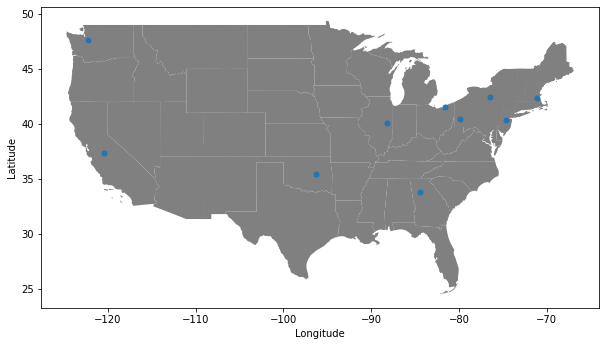

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
states.plot(color="gray", ax=ax, )
uni_data.plot(x="Longitude", y="Latitude", kind="scatter", s=25, colormap="Blues", ax=ax)
plt.show()